In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 모델 학습 중 사용할 콜백들
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 추가적으로 파일 경로를 다룰 경우 os 사용 가능
import os

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

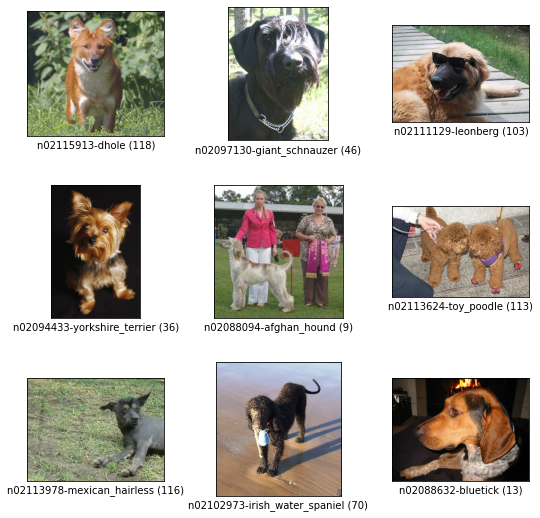

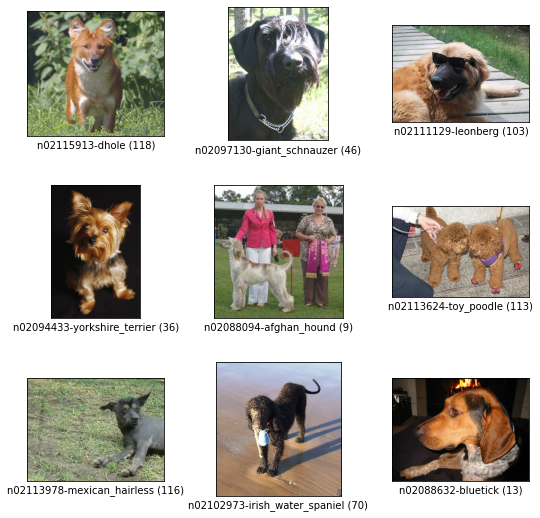

In [5]:
tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(image, label):
    # 이미지를 224x224로 리사이즈하고 0-1 범위로 정규화
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    # 증강을 더 추가: 회전, 확대/축소, 대비 조정
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조정 추가
    image = tf.image.random_saturation(image, lower=0.6, upper=1.4)  # 채도 조정 추가
    image = tf.image.random_hue(image, max_delta=0.08)  # 색조 조정 추가
    image = tf.image.random_jpeg_quality(image, 70, 100)  # JPEG 품질 랜덤 적용
    image = tf.image.random_rotation(image, angles=20)  # 회전 추가
    image = tf.clip_by_value(image, 0, 1)  # 값이 0과 1을 넘지 않도록
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    # 데이터 전처리: 정규화 및 리사이즈
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    # 증강 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    
    # 배치 처리
    ds = ds.batch(batch_size)
    
    # 레이블을 원-핫 인코딩
    ds = ds.map(
        onehot,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    # 학습 데이터에 반복 및 셔플 적용
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [7]:
num_classes = ds_info.features["label"].num_classes

# 기본 ResNet50 모델
resnet50 = keras.models.Sequential([
    keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.BatchNormalization(),  # Batch Normalization 추가
    keras.layers.Dropout(0.5),  # Dropout 추가
    keras.layers.Dense(
        num_classes, 
        activation='softmax', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)  # L1 및 L2 규제 추가
    )
])

# 증강을 사용하는 ResNet50 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.BatchNormalization(),  # Batch Normalization 추가
    keras.layers.Dropout(0.5),  # Dropout 추가
    keras.layers.Dense(
        num_classes, 
        activation='softmax', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)  # L1 및 L2 규제 추가
    )
])

# Transfer Learning: ResNet50의 상위 레이어만 학습 가능하도록 설정
for layer in resnet50.layers[0].layers[:140]:  # 140번째 레이어까지 동결
    layer.trainable = False

for layer in aug_resnet50.layers[0].layers[:140]:
    layer.trainable = False

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(144, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(75, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


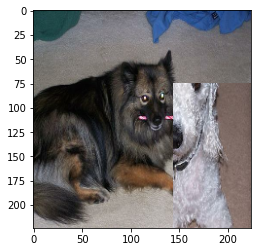

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.23756377, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [13]:
# CutMix 적용 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        # 두 번째 이미지를 무작위로 선택
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 랜덤 클립 박스 추출
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        
        # 이미지 크기 계산 후 레이블 섞기
        image_size_x = image_a.shape[1]
        image_size_y = image_a.shape[0]
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size_x, image_size_y))

    # 최종적으로 배치 크기에 맞춰 이미지를 합침
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

In [22]:
# Mixup 함수 정의 (numpy 사용)
def mixup(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    # Mixup에 사용할 lambda 값 설정 (Beta 분포에서 추출)
    lambda_value = np.random.beta(0.2, 0.2, batch_size)

    for i in range(batch_size):
        image_a = image[i]
        label_a = tf.one_hot(label[i], num_classes)  # 원-핫 인코딩 추가

        # 두 번째 이미지를 임의로 선택
        j = np.random.randint(0, batch_size)
        image_b = image[j]
        label_b = tf.one_hot(label[j], num_classes)  # 원-핫 인코딩 추가

        # 이미지 섞기
        lam = lambda_value[i]  # i번째 이미지에 해당하는 lambda 값
        mixed_image = lam * image_a + (1 - lam) * image_b
        mixed_label = lam * label_a + (1 - lam) * label_b

        mixed_imgs.append(mixed_image)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

# 데이터셋 처리 함수 (중복 제거 후)
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    # 데이터 전처리: 정규화 및 리사이즈
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    # 증강 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    
    # 배치 처리 및 Mixup/원-핫 인코딩 적용
    ds = ds.batch(batch_size)
    if not is_test:
        if with_mixup:
            ds = ds.map(
                lambda image, label: mixup(image, label, batch_size=batch_size, img_size=224, num_classes=num_classes),
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        else:
            ds = ds.map(
                onehot,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
    
    # 학습 데이터에 반복 및 셔플 적용
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [23]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,  # (image, label) 형태로 데이터셋 불러옴
    shuffle_files=True,
    with_info=True,
)

# 증강 미적용 데이터셋
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=False)

# Mixup 증강을 적용한 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

# 테스트 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

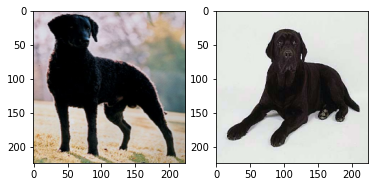

In [24]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [25]:
for image, label in ds_train_no_aug.take(1):
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16, 120)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 'val_accuracy'도 가능
    patience=3,          # 개선되지 않는 에포크가 3번 이상이면 중지
    restore_best_weights=True  # 가장 좋은 가중치 복원
)

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 성능 개선이 없을 때 학습률을 줄임
    factor=0.2,          # 학습률을 20%로 감소시킴
    patience=2,          # 개선되지 않는 에포크가 2번 이상이면 감소
    min_lr=1e-6          # 최소 학습률을 설정
)

EPOCH = 20

# 모델 컴파일 (Adam 옵티마이저 사용)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam 옵티마이저 사용
    metrics=['accuracy'],
)

# 모델 학습
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,  # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr],  # EarlyStopping 및 ReduceLROnPlateau 콜백 추가
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 159s 197ms/step - loss: 2.1896 - accuracy: 0.4502 - val_loss: 3.1622 - val_accuracy: 0.2437
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 0.7113 - accuracy: 0.8048 - val_loss: 1.0837 - val_accuracy: 0.6858
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 0.2691 - accuracy: 0.9395 - val_loss: 1.1043 - val_accuracy: 0.6817
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0815 - accuracy: 0.9897 - val_loss: 0.9267 - val_accuracy: 0.7340
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0310 - accuracy: 0.9983 - val_loss: 0.9002 - val_accuracy: 0.7456
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0155 - accuracy: 0.9998 - val_loss: 0.9088 - val_accuracy: 0.7467
Epoch 7/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0130 - accuracy: 0.9992 - val_loss: 0.9211 -

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 또는 'val_accuracy'
    patience=3,          # 개선되지 않는 에포크가 3번 이상이면 중지
    restore_best_weights=True  # 가장 좋은 가중치 복원
)

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 성능 개선이 없을 때 학습률을 줄임
    factor=0.2,          # 학습률을 20%로 감소시킴
    patience=2,          # 개선되지 않는 에포크가 2번 이상이면 감소
    min_lr=1e-6          # 최소 학습률 설정
)

EPOCH = 20  # 학습 에포크 설정

# 모델 컴파일 (Adam 옵티마이저 사용)
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam 옵티마이저 사용
    metrics=['accuracy'],
)

# 모델 학습
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,  # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr],  # EarlyStopping 및 ReduceLROnPlateau 콜백 추가
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 207ms/step - loss: 2.9522 - accuracy: 0.3492 - val_loss: 3.6406 - val_accuracy: 0.1805
Epoch 2/20
750/750 [==============================] - 170s 227ms/step - loss: 1.6167 - accuracy: 0.6941 - val_loss: 1.3973 - val_accuracy: 0.6145
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 1.1859 - accuracy: 0.8447 - val_loss: 1.5275 - val_accuracy: 0.5871
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 0.9377 - accuracy: 0.9259 - val_loss: 1.0928 - val_accuracy: 0.6972
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 0.8349 - accuracy: 0.9579 - val_loss: 1.1845 - val_accuracy: 0.6740
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.7733 - accuracy: 0.9682 - val_loss: 1.0904 - val_accuracy: 0.7004
Epoch 7/20
750/750 [==============================] - 171s 228ms/step - loss: 0.7280 - accuracy: 0.9778 - val_loss: 1.0921 -

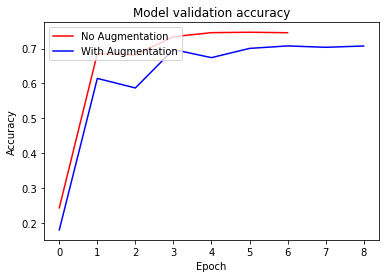

In [28]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

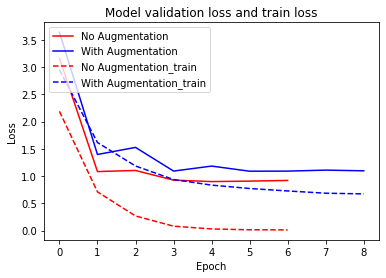

In [29]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_no_aug.history['loss'], '--r')
plt.plot(history_resnet50_aug.history['loss'], '--b')
plt.title('Model validation loss and train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'No Augmentation_train', 'With Augmentation_train'], loc='upper left')
plt.show()

# Cutmix 결과

* ### 일단 epoch을 10으로 하고, Early stopping도 넣지않고 빠르게 성능을 확인해보고싶었다. 후회했다.
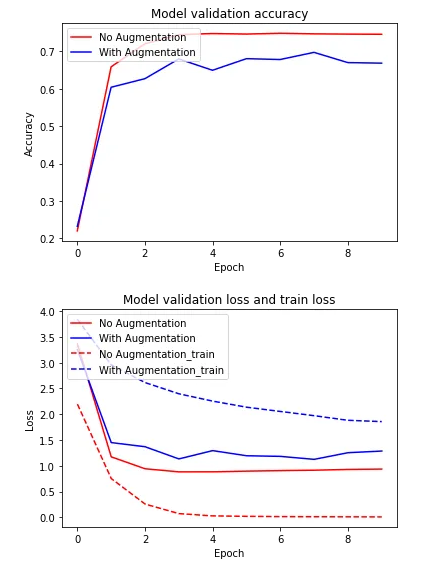

* ### 후회해서 Early stopping을 넣었는데 뭐 달라지는게 없다
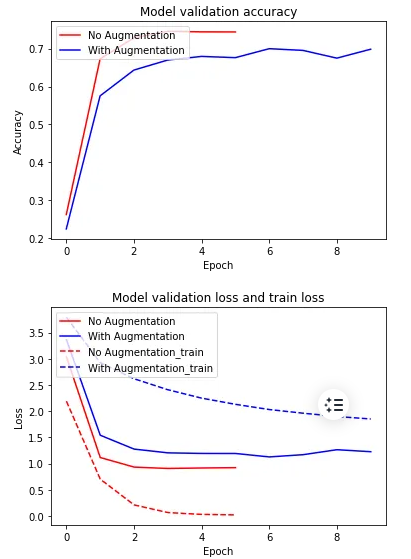

# Mixup 사용

* ### 근데 다 결국 Augmentation넣으면 성능이 안좋다

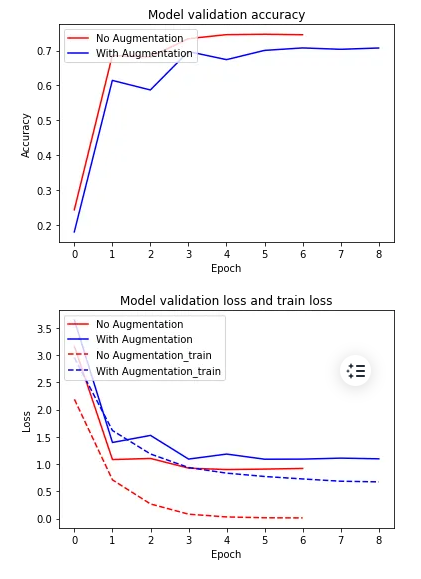

## 회고

* ### 성능 올리려고 ReduceLROnPlateau / Rotation, Zoom, Shift 증강 추가/ Drop out 추가 / L1, L2규제 넣기 / Batch Normalization 추가/ Optimizer Adam으로 변경 / Transfer Learning 활용으로 특정 레이어 학습에 추가 를 알아보고 삽입해보려 했으나 엄청난 에러덩어리였다.

* ### GPT와 열심히 해보려했는데 결국 실패했다

* ### 스킬을 늘려서 위의 것들을 다 추가할 수 있으면 좋겠다.... GPT도 모르고 나도 모르는 에러 해결방법...

# 위의 내용 담아서 최대한 정리해서 해보려 한 버전

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
# get_clip_box 함수 정의
def get_clip_box(image_a, image_b):
    """
    두 이미지의 교차 영역을 정의하는 클립 박스 좌표를 계산하는 함수입니다.
    image_a, image_b는 같은 크기여야 하며, 랜덤하게 교차 영역을 설정합니다.
    """
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # 박스 중심을 랜덤하게 설정
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # 박스의 너비와 높이 결정
    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    # 이미지 경계를 벗어나지 않도록 좌표 조정
    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)
    
    return x_min, y_min, x_max, y_max

# mix_2_images 함수 정의
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    """
    두 이미지를 지정된 좌표 범위에서 섞는 함수입니다.
    image_a의 특정 영역을 image_b의 해당 영역으로 대체합니다.
    """
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # 이미지 중앙 영역을 결합
    middle_left = image_a[y_min:y_max, 0:x_min, :]
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    
    # 상단과 하단 결합
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

# mix_2_labels 함수 정의
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size_x, image_size_y, num_classes=120):
    """
    두 레이블을 섞는 함수입니다. 섞인 이미지 영역의 비율에 따라 두 레이블을 결합합니다.
    """
    # 섞인 영역의 크기 비율을 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    # 레이블 원-핫 인코딩
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)

    # 두 레이블을 비율에 맞춰 결합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    
    return mixed_label

# CutMix 함수 정의
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    """
    CutMix 데이터 증강을 적용하는 함수입니다.
    두 이미지를 섞고, 그에 맞춰 레이블도 섞습니다.
    """
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]

        # 두 번째 이미지를 무작위로 선택
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 섞을 영역 좌표를 계산
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지와 레이블을 섞음
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        image_size_x = image_a.shape[1]
        image_size_y = image_a.shape[0]
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size_x, image_size_y))

    # 배치 단위로 섞인 이미지와 레이블을 반환
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

# Mixup 함수 정의
def mixup(image, label, batch_size=16, img_size=224, num_classes=120):
    """
    Mixup 데이터 증강을 적용하는 함수입니다.
    두 이미지를 랜덤한 비율로 섞고, 레이블도 그에 맞춰 섞습니다.
    """
    mixed_imgs = []
    mixed_labels = []

    # Beta 분포에서 lambda 값을 추출
    lambda_value = np.random.beta(0.2, 0.2, batch_size)

    for i in range(batch_size):
        image_a = image[i]
        label_a = tf.one_hot(label[i], num_classes)

        # 두 번째 이미지를 임의로 선택
        j = np.random.randint(0, batch_size)
        image_b = image[j]
        label_b = tf.one_hot(label[j], num_classes)

        # 이미지와 레이블을 lambda 값에 따라 섞기
        lam = lambda_value[i]
        mixed_image = lam * image_a + (1 - lam) * image_b
        mixed_label = lam * label_a + (1 - lam) * label_b

        mixed_imgs.append(mixed_image)
        mixed_labels.append(mixed_label)

    # 배치 단위로 섞인 이미지와 레이블을 반환
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# 증강 미적용 데이터셋
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=False)

# Mixup 증강을 적용한 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

# 테스트 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# 데이터셋 정보에서 클래스 수 가져오기
# 'ds_info'는 데이터셋 로딩 후에 정의되므로 그 이후에 사용해야 합니다.
num_classes = ds_info.features['label'].num_classes

# 이미지 정규화 및 리사이즈 함수 정의
def normalize_and_resize_img(image, label):
    """
    이미지를 224x224로 리사이즈하고 0-1 범위로 정규화하는 함수입니다.
    """
    # 이미지 차원이 3 또는 4인지 확인
    if len(image.shape) == 3:  # 단일 이미지 (height, width, channels)
        image = tf.image.resize(image, [224, 224])
    elif len(image.shape) == 4:  # 배치 처리된 이미지 (batch_size, height, width, channels)
        image = tf.map_fn(lambda img: tf.image.resize(img, [224, 224]), image)
    
    return tf.cast(image, tf.float32) / 255., label

# 데이터 증강 함수 정의
def augment(image, label):
    """
    데이터 증강을 위한 함수입니다.
    좌우 반전, 밝기 조정, 대비 조정 등을 수행합니다.
    """
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2)  # 밝기 조정
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조정
    image = tf.image.random_saturation(image, lower=0.6, upper=1.4)  # 채도 조정
    image = tf.image.random_hue(image, max_delta=0.08)  # 색상 조정
    image = tf.clip_by_value(image, 0, 1)  # 값이 0과 1을 넘지 않도록 클리핑
    return image, label

# 레이블 원-핫 인코딩 함수 정의
def onehot(image, label):
    """
    레이블을 원-핫 인코딩하는 함수입니다.
    num_classes 값을 사용합니다.
    """
    label = tf.one_hot(label, num_classes)  # num_classes 변수를 참조
    return image, label

# 전처리 및 증강 적용 함수 정의
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    """
    데이터셋에 대해 정규화, 리사이즈, 증강, Mixup/CutMix를 적용하는 함수입니다.
    """
    # 정규화 및 리사이즈
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # 증강 적용 여부 (테스트 데이터셋에는 적용하지 않음)
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # 배치 단위로 묶음 (여기서 추가로 중첩되지 않도록 주의)
    ds = ds.batch(batch_size)
    
    # Mixup 또는 원-핫 인코딩 적용
    if not is_test:
        if with_mixup:
            ds = ds.map(lambda image, label: mixup(image, label, batch_size=batch_size, img_size=224, num_classes=num_classes), 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
        else:
            # 원-핫 인코딩을 적용하여 레이블을 변환
            ds = ds.map(onehot, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # 학습 데이터에 반복 및 셔플 적용 (테스트 데이터에는 적용 안 함)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    # 데이터 전처리 속도 향상을 위해 prefetch 사용
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [ ]:
# 이미지 및 레이블을 가져옵니다.
for image, label in ds_train_no_aug.take(1):
    image_a = image[0].numpy()  # .numpy()로 변환하여 시각화 가능
    image_b = image[1].numpy()  # .numpy()로 변환
    label_a = label[0].numpy()  # 레이블도 .numpy()로 변환
    label_b = label[1].numpy()  # 레이블도 .numpy()로 변환
    break

# 첫 번째 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(image_a)
plt.title(f"Label A: {label_a}")

# 두 번째 이미지 시각화
plt.subplot(1, 2, 2)
plt.imshow(image_b)
plt.title(f"Label B: {label_b}")

plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras

# 데이터셋 정보에서 클래스 수 가져오기
num_classes = ds_info.features["label"].num_classes

# 기본 ResNet50 모델 정의
resnet50 = keras.models.Sequential([
    keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.BatchNormalization(),  # Batch Normalization 추가
    keras.layers.Dropout(0.5),  # Dropout 추가
    keras.layers.Dense(
        num_classes, 
        activation='softmax', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)  # L1 및 L2 규제 추가
    )
])

# 증강을 사용하는 ResNet50 모델 정의
aug_resnet50 = keras.models.Sequential([
    keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.BatchNormalization(),  # Batch Normalization 추가
    keras.layers.Dropout(0.5),  # Dropout 추가
    keras.layers.Dense(
        num_classes, 
        activation='softmax', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)  # L1 및 L2 규제 추가
    )
])

# Transfer Learning: ResNet50의 하위 레이어를 동결
for layer in resnet50.layers[:140]:  # 140번째 레이어까지 동결
    layer.trainable = False

for layer in aug_resnet50.layers[:140]:  # 증강 모델에서도 동일하게 동결
    layer.trainable = False

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 'val_accuracy'도 가능
    patience=3,          # 개선되지 않는 에포크가 3번 이상이면 중지
    restore_best_weights=True  # 가장 좋은 가중치 복원
)

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 성능 개선이 없을 때 학습률을 줄임
    factor=0.2,          # 학습률을 20%로 감소시킴
    patience=2,          # 개선되지 않는 에포크가 2번 이상이면 감소
    min_lr=1e-6          # 최소 학습률을 설정
)

EPOCH = 20

# **중요**: 모델 학습 시 레이블이 원-핫 인코딩되어 있음을 확인합니다.
# 원-핫 인코딩이 제대로 되어 있지 않으면 `SparseCategoricalCrossentropy` 사용 고려
# 모델 컴파일 (Adam 옵티마이저 사용)
resnet50.compile(
    loss='categorical_crossentropy',  # 레이블이 원-핫 인코딩되었다면 categorical_crossentropy 사용
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam 옵티마이저 사용
    metrics=['accuracy'],
)

# 모델 학습 (증강 미적용)
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,  # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr],  # EarlyStopping 및 ReduceLROnPlateau 콜백 추가
    verbose=1,
    use_multiprocessing=True,
)

# 증강을 사용하는 ResNet50 모델 학습
aug_resnet50.compile(
    loss='categorical_crossentropy',  # 레이블이 원-핫 인코딩되었으므로 categorical_crossentropy 사용
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam 옵티마이저 사용
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,  # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[early_stopping, reduce_lr],  # EarlyStopping 및 ReduceLROnPlateau 콜백 추가
    verbose=1,
    use_multiprocessing=True,
)


In [ ]:
import matplotlib.pyplot as plt

# 1행 2열로 subplot 생성
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 첫 번째 subplot: accuracy (train and validation)
axs[0].plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
axs[0].plot(history_resnet50_aug.history['val_accuracy'], 'b')
axs[0].plot(history_resnet50_no_aug.history['accuracy'], '--r')  # Train accuracy 추가
axs[0].plot(history_resnet50_aug.history['accuracy'], '--b')     # Train accuracy 추가
axs[0].set_title('Model accuracy (Train and Validation)')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['No Augmentation (Val)', 'With Augmentation (Val)', 'No Augmentation (Train)', 'With Augmentation (Train)'], loc='upper left')

# 두 번째 subplot: loss (train and validation)
axs[1].plot(history_resnet50_no_aug.history['val_loss'], 'r')
axs[1].plot(history_resnet50_aug.history['val_loss'], 'b')
axs[1].plot(history_resnet50_no_aug.history['loss'], '--r')  # Train loss 추가
axs[1].plot(history_resnet50_aug.history['loss'], '--b')     # Train loss 추가
axs[1].set_title('Model loss (Train and Validation)')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['No Augmentation (Val)', 'With Augmentation (Val)', 'No Augmentation (Train)', 'With Augmentation (Train)'], loc='upper left')

# 그래프를 보기 위해 레이아웃 조정
plt.tight_layout()
plt.show()

## 결과: 처참히 실패 에러 엄청 많음